In [1]:
import numpy as np
from numpy import outer, trace, dot, pi, log, exp, sin, cos, sqrt
from scipy.linalg import eig, eigh, norm, svd, kron, expm, sqrtm
from scipy.stats import gaussian_kde, unitary_group
from scipy.optimize import minimize

import qutip as qp
from qiskit.quantum_info import Operator
from qiskit.circuit import Parameter
from qiskit.compiler import transpile

import time
import random
from functools import reduce

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute

import mpmath as mp
mp.dps = 250; mp.pretty = False

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
s0 = np.array([[1],
               [0]])
P0 = np.array([[1., 0.],
               [0., 0.]]) # |0><0|
P1 = np.array([[0., 0.],
               [0., 1.]]) # |1><1|
X = np.array([[0.,1.],
              [1.,0.]]) # X Pauli matrix
Y = np.array([[0.,-1.j],
              [1.j, 0.]]) # Y Pauli matrix
Z = np.array([[1., 0.],
              [0.,-1.]]) # Z Pauli matrix
I = np.array([[1.,0.],
              [0.,1.]]) # 2x2 identity matrix
H = (X + Z) / sqrt(2)
XX = kron(X, X)
YY = kron(Y, Y)
ZZ = kron(Z, Z)

In [3]:
swap = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1]])

cswap = reduce(kron, [P0, I, I]) + reduce(kron, [P1, swap])

In [4]:
def su2(parameters):
    
    c_11 =  exp(1j * (-parameters[1] - parameters[2])) * cos(parameters[0])
    c_12 = -exp(1j * (-parameters[1] + parameters[2])) * sin(parameters[0])
    c_21 =  exp(1j * ( parameters[1] - parameters[2])) * sin(parameters[0])
    c_22 =  exp(1j * ( parameters[1] + parameters[2])) * cos(parameters[0])
    operator = np.array([[c_11, c_12],
                         [c_21, c_22]])
    
    return operator


def su4(parameters):
    
    op_11 = su2([parameters[0], parameters[1], parameters[2]])
    op_12 = su2([parameters[3], parameters[4], parameters[5]])
    op_1 = kron(op_11, op_12)
    
    op_2 = expm(1j * (parameters[6]*XX + parameters[7]*YY + parameters[8]*ZZ))
    
    op_31 = su2([parameters[9], parameters[10], parameters[11]])
    op_32 = su2([parameters[12], parameters[13], parameters[14]])
    op_3 = kron(op_31, op_32)
    
    return op_3.dot(op_2).dot(op_1)

In [5]:
def fidelity(dm1, dm2):
    
    dm1_sqrt = sqrtm(dm1)
    
    dm = sqrtm(dm1_sqrt.dot(dm2).dot(dm1_sqrt))

    return (trace(dm)).real**2

In [6]:
def random_hermitian(qubits_number, distribution='uniform'):
    
    d = 2**qubits_number
    
    if distribution == 'uniform':
        hermitian = np.array([[np.random.uniform(-1, 1) for i in range(d)] for i in range(d)]) + 1.j * np.array([[np.random.uniform(-1, 1) for i in range(d)] for i in range(d)])
    if distribution == 'gaussian':
        hermitian = np.array([[np.random.normal() for i in range(d)] for i in range(d)]) + 1.j * np.array([[np.random.normal() for i in range(d)] for i in range(d)]) 

    hermitian = (hermitian + hermitian.T.conj())/2
    
    return hermitian

In [7]:
def schwinger_model(n_qubits, w, m, g):
    
    d = 2**n_qubits
    
    sp = (X + 1j * Y) / 2
    sm = (X - 1j * Y) / 2
    
    term_1 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        k = (j + 1) % n_qubits
        crea = [I]*j + [sp] + [I]*(n_qubits - j - 1)
        anni = [I]*k + [sm] + [I]*(n_qubits - k - 1)
        crea = reduce(kron, crea)
        anni = reduce(kron, anni)
        op = crea.dot(anni)
        term_1 = term_1 + op + op.conj().T
    term_1 = w * term_1

    term_2 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        operator = [I]*j + [Z] + [I]*(n_qubits - 1 - j)
        term_2 = term_2 + (-1)**(j + 1) * reduce(kron, operator)
    term_2 = m / 2 * term_2

    term_3 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        L = 1j * np.zeros((d, d))
        for l in range(j + 1):
            operator = [I]*n_qubits
            operator[l] = Z + (-1)**(l + 1) * I
            L = L - 0.5 * reduce(kron, operator)
        term_3 = term_3 + L.dot(L)
    term_3 = g * term_3
        
    return term_1 + term_2 + term_3

In [8]:
def local_depolarizing_channel(n_qubits, density_matrix, p, target_qubit):
    
    X_loc = [I] * n_qubits
    X_loc[target_qubit] = X
    X_loc = reduce(kron, X_loc)
    
    Y_loc = [I] * n_qubits
    Y_loc[target_qubit] = Y
    Y_loc = reduce(kron, Y_loc)
    
    Z_loc = [I] * n_qubits
    Z_loc[target_qubit] = Z
    Z_loc = reduce(kron, Z_loc)
    
    new_density_matrix = (1 - p)*density_matrix + (X_loc.dot(density_matrix).dot(X_loc) + Y_loc.dot(density_matrix).dot(Y_loc) + Z_loc.dot(density_matrix).dot(Z_loc)) * p / 3
        
    return new_density_matrix


def colored_noise_channel(n_qubits, density_matrix, t, alpha, target_qubit, gamma1=1e-4, gamma2=1e4):

    if alpha == 1:
        a = mp.log(mp.fdiv(gamma2, gamma1))
        c = mp.fdiv(1, a)
        def p(gamma):
            return mp.fmul(c, mp.fdiv(1, gamma))
    else:
        k = mp.fsub(alpha, 1)
        a = mp.fmul(gamma1, gamma2)
        a_power = mp.power(a, k)
        b = mp.fsub(mp.power(gamma2, k), mp.power(gamma1, k))
        c = mp.fdiv(a_power, b)
        def p(gamma):
            pp = mp.power(gamma, alpha)
            f = mp.fdiv(k, pp)
            return mp.fmul(f, c)
   
    def G(gamma):
        delta = mp.sqrt(gamma**2 - 4)
        delta_t = mp.fmul(delta, t)
        second = mp.fadd(mp.cosh(delta_t), mp.fdiv(mp.fmul(gamma, mp.sinh(delta_t)), delta))
        gamma_t = mp.fmul(gamma, t)
        return mp.fmul(mp.exp(-gamma_t), second)
        
    L = mp.quad(lambda gamma: mp.fmul(p(gamma), G(gamma)), [gamma1, gamma2])
    L = float(L.real)
    operator = [I] * n_qubits
    operator[target_qubit] = Z
    operator = reduce(kron, operator)
    term1 = (1 + L) / 2 * density_matrix
    term2 = (1 - L) / 2 * operator.dot(density_matrix).dot(operator)
    
    return np.array(term1 + term2, dtype=complex)

# v0: test of Hamiltonian eigenstates classification

No circuits, just matrix multiplication.

In [318]:
def train(dm_train, labels, method):
    
    f_values = []
    n_train = len(dm_train)
    
    # estimate the kernel
    K = np.zeros((n_train, n_train))
    for i in range(n_train):
        for j in range(i + 1):
            K[i][j] = K[j][i] = trace(dot(dm_train[i], dm_train[j])).real
            
    # hinge loss
    def fun(x):
        
        term1 = 0
        term2 = 0
        
        for i in range(n_train):
            term1 += x[i]
            for j in range(n_train):
                term2 += labels[i]*labels[j]*x[i]*x[j]*K[i][j]
        
        f = term1 - 0.5*term2
        f_values.append(f)
        
        return -f
    
    
    # train the model #
    
    # find optimal parameters
    bounds = [(0, None)] * n_train
    x0 = [random.uniform(0, 1) for i in range(n_train)]
    constraints = {'type': 'eq',
                   'fun': lambda x: dot(x, labels)}
    optimization_result = minimize(fun=fun, x0=x0, method=method, bounds=bounds, constraints=constraints)
    parameters = optimization_result.x
    
    # find bias

    for i in range(n_train):
        if np.round(parameters[i], 3) > 0:
            index = i
            break
            
    s = 0
    for i in range(n_train):
#         if i != index:
            s += labels[i]*parameters[i]*K[i][index]
        
    bias = labels[index] - s
    
    
    return parameters, bias, f_values, optimization_result, K

In [319]:
def classify(labels_train, parameters, bias, dm_train, dm_test):
    
    assignments = []
    m_values = []
    n_train = len(dm_train)
    n_test = len(dm_test)
    
    for i in range(n_test):
        
        s = 0
        for j in range(n_train):
            s += labels_train[j]*parameters[j]*trace(dot(dm_train[j], dm_test[i])).real
        
        m = s + bias
        m_values.append(m)
        assignments.append(np.sign(m))
        
    return assignments, m_values

#### Training accuracy

In [320]:
n_train = 100
regions = [(0, 1/2), (1/2, 4)]
class_labels = [-1, 1]
n_classes = len(class_labels)

ham1 = random_hermitian(1)
ham2 = random_hermitian(1)


alphas_train = []
labels_train = []
dm_train = []

for i in range(n_train):
    
    label = random.sample(class_labels, 1)[0]
    labels_train.append(label)
    
    index = 0
    for j in range(n_classes):
        if label == class_labels[j]:
            index = j
    
    alpha = random.uniform(regions[index][0], regions[index][1])
    alphas_train.append(alpha)
    
    hamiltonian = alpha*ham1 + (1 - alpha)*ham2
    
    state_vector = eigh(hamiltonian)[1][:,0]
    density_matrix = outer(state_vector.conj(), state_vector)
    dm_train.append(density_matrix)

Completed in 66.64222192764282


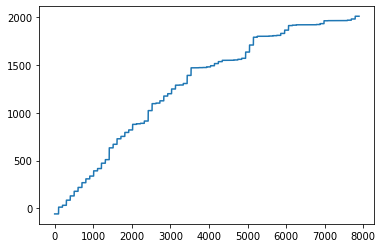

Bias: -0.0176771535795055


In [321]:
method = 'SLSQP'

start_time = time.time()
parameters, bias, f_values, optimization_result, K = train(dm_train, labels_train, method)
print('Completed in', time.time() - start_time)

x_axis = np.arange(len(f_values))
plt.plot(x_axis, f_values)
plt.show()

print('Bias:', bias)

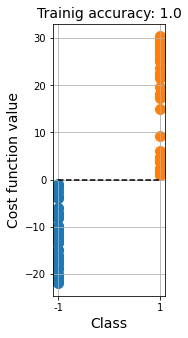

In [322]:
assignments_train, predictions_train = classify(labels_train, parameters, bias, dm_train, dm_train)

ps = 0
for i in range(n_train):
    if labels_train[i] == assignments_train[i]:
        ps += 1
acc_train = ps/n_train

predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_train):
    for j in range(n_classes):
        if labels_train[i] == class_labels[j]:
            predictions_plot[j].append(predictions_train[i])

plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    plt.scatter(x, y, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=0, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
# plt.hlines(y=1, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='solid')      
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Trainig accuracy: ' + str(acc_train), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
# plt.ylim(ymin=-1.05, ymax=1.05)
plt.grid()
plt.show()

#### Classification accuracy

In [323]:
n_test = 100

labels_test = []
alphas_test = []
dm_test = []

for i in range(n_test):
    
    label = random.sample(class_labels, 1)[0]
    labels_test.append(label)
    
    index = 0
    for j in range(n_classes):
        if label == class_labels[j]:
            index = j
    
    alpha = random.uniform(regions[index][0], regions[index][1])
    alphas_test.append(alpha)
    
    hamiltonian = alpha*ham1 + (1 - alpha)*ham2
    
    state_vector = eigh(hamiltonian)[1][:,0]
    density_matrix = outer(state_vector.conj(), state_vector)
    dm_test.append(density_matrix)

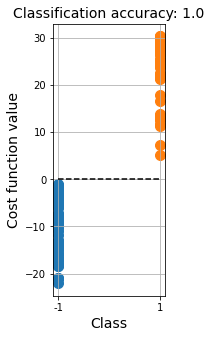

In [324]:
assignments_test, predictions_test = classify(labels_train, parameters, bias, dm_train, dm_test)

ps = 0
for i in range(n_test):
    if labels_test[i] == assignments_test[i]:
        ps += 1
acc_test = ps/n_test


predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_test):
    for j in range(n_classes):
        if labels_test[i] == class_labels[j]:
            predictions_plot[j].append(predictions_test[i])

plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    plt.scatter(x, y, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=0, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed') 
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Classification accuracy: ' + str(acc_test), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
plt.grid()
plt.show()

# v1: test for channels with random $\alpha$s with $\alpha_1 \leqslant \alpha_c < \alpha_2$ and $\vert + \rangle$ probe state

No circuits, just matrix multiplication.

In [325]:
def train(dm_train, labels, method):
    
    f_values = []
    n_train = len(dm_train)
    
    # estimate the kernel
    K = np.zeros((n_train, n_train))
    for i in range(n_train):
        for j in range(i + 1):
            K[i][j] = K[j][i] = trace(dot(dm_train[i], dm_train[j])).real
            
    # hinge loss
    def fun(x):
        
        term1 = 0
        term2 = 0
        
        for i in range(n_train):
            term1 += x[i]
            term2 += 0.5*labels[i]*x[i]*x[i]*labels[i]*K[i][i]
            for j in range(i):
                term2 += labels[i]*labels[j]*x[i]*x[j]*K[i][j]
        
        f = term1 - term2
        f_values.append(f)
        
        return -f
    
    
    # train the model #
    
    # find optimal parameters
    bounds = [(0, None)] * n_train
    x0 = [random.uniform(0, 1) for i in range(n_train)]
    constraints = {'type': 'eq',
                   'fun': lambda x: dot(x, labels)}
    optimization_result = minimize(fun=fun, x0=x0, method=method, bounds=bounds, constraints=constraints)
    parameters = optimization_result.x
    
    # find bias

    for i in range(n_train):
        if np.round(parameters[i], 4) > 0:
            index = i
            break
            
    s = 0
    for i in range(n_train):
        s += labels[i]*parameters[i]*K[i][index]
        
    bias = labels[index] - s
    
    
    return parameters, bias, f_values, optimization_result, K

In [326]:
def classify(labels_train, parameters, bias, dm_train, dm_test):
    
    assignments = []
    m_values = []
    n_train = len(dm_train)
    n_test = len(dm_test)
    
    for i in range(n_test):
        
        s = 0
        for j in range(n_train):
            s += labels_train[j]*parameters[j]*trace(dot(dm_train[j], dm_test[i])).real
        
        m = s + bias
        m_values.append(m)
        assignments.append(np.sign(m))
        
    return assignments, m_values

#### Training accuracy

In [328]:
n_train = 100
regions = [(1.2, 1.5), (1.5, 2)]
class_labels = [-1, 1]
n_classes = len(class_labels)


alphas_train = []
labels_train = []
dm_train = []

for i in range(n_train):
    
    label = random.sample(class_labels, 1)[0]
    labels_train.append(label)
    
    index = 0
    for j in range(n_classes):
        if label == class_labels[j]:
            index = j
    
    alpha = random.uniform(regions[index][0], regions[index][1])
    alphas_train.append(alpha)
    
#     state_vector = np.array(qp.rand_ket_haar(2))
    state_vector = np.array([1, 1]) / sqrt(2)
    density_matrix = outer(state_vector, state_vector.conj().T)
    
#     density_matrix = local_depolarizing_channel(1, density_matrix, alpha, 0)
    density_matrix = colored_noise_channel(1, density_matrix, pi/2, alpha, 0, gamma1=1e-4, gamma2=1e4)
    
    dm_train.append(density_matrix)

Completed in 43.62144374847412


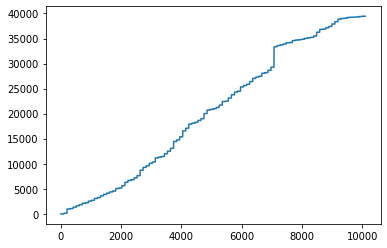

Bias: -102.81876617650005


In [329]:
method = 'SLSQP'

start_time = time.time()
parameters, bias, f_values, optimization_result, K = train(dm_train, labels_train, method)
print('Completed in', time.time() - start_time)

x_axis = np.arange(len(f_values))
plt.plot(x_axis, f_values)
plt.show()

print('Bias:', bias)

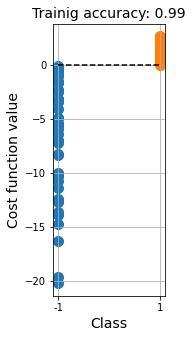

In [330]:
assignments_train, predictions_train = classify(labels_train, parameters, bias, dm_train, dm_train)

ps = 0
for i in range(n_train):
    if labels_train[i] == assignments_train[i]:
        ps += 1
acc_train = ps/n_train

predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_train):
    for j in range(n_classes):
        if labels_train[i] == class_labels[j]:
            predictions_plot[j].append(predictions_train[i])

plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    plt.scatter(x, y, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=0, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
# plt.hlines(y=1, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='solid')      
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Trainig accuracy: ' + str(acc_train), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
# plt.ylim(ymin=-1.05, ymax=1.05)
plt.grid()
plt.show()

#### Classification accuracy

In [332]:
n_test = 100

labels_test = []
alphas_test = []
dm_test = []

for i in range(n_test):
    
    label = random.sample(class_labels, 1)[0]
    labels_test.append(label)
    
    index = 0
    for j in range(n_classes):
        if label == class_labels[j]:
            index = j
    
    alpha = random.uniform(regions[index][0], regions[index][1])
    alphas_test.append(alpha)
    
    state_vector = np.array([1, 1]) / sqrt(2)
    density_matrix = outer(state_vector, state_vector.conj().T)
    
#     density_matrix = local_depolarizing_channel(1, density_matrix, alpha, 0)
    density_matrix = colored_noise_channel(1, density_matrix, pi/2, alpha, 0, gamma1=1e-4, gamma2=1e4)
    
    dm_test.append(density_matrix)

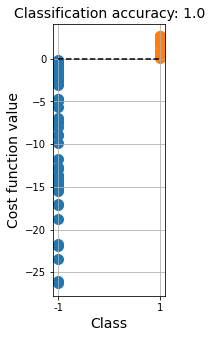

In [333]:
assignments_test, predictions_test = classify(labels_train, parameters, bias, dm_train, dm_test)

ps = 0
for i in range(n_test):
    if labels_test[i] == assignments_test[i]:
        ps += 1
acc_test = ps/n_test


predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_test):
    for j in range(n_classes):
        if labels_test[i] == class_labels[j]:
            predictions_plot[j].append(predictions_test[i])

plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    plt.scatter(x, y, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=0, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed') 
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Classification accuracy: ' + str(acc_test), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
plt.grid()
plt.show()

# v2: test for channels with fixed $\alpha_1, \alpha_2$ and random probe states

No circuits, just matrix multiplication.

In [334]:
def train(dm_train, labels, method):
    
    f_values = []
    n_train = len(dm_train)
    
    # estimate the kernel
    K = np.zeros((n_train, n_train))
    for i in range(n_train):
        for j in range(i + 1):
            K[i][j] = K[j][i] = trace(dot(dm_train[i], dm_train[j])).real
            
    # hinge loss
    def fun(x):
        
        term1 = 0
        term2 = 0
        
        for i in range(n_train):
            term1 += x[i]
            term2 += 0.5*labels[i]*x[i]*x[i]*labels[i]*K[i][i]
            for j in range(i):
                term2 += labels[i]*labels[j]*x[i]*x[j]*K[i][j]
        
        f = term1 - term2
        f_values.append(f)
        
        return -f
    
    
    # train the model #
    
    # find optimal parameters
    bounds = [(0, None)] * n_train
    x0 = [random.uniform(0, 1) for i in range(n_train)]
    constraints = {'type': 'eq',
                   'fun': lambda x: dot(x, labels)}
    optimization_result = minimize(fun=fun, x0=x0, method=method, bounds=bounds, constraints=constraints)
    parameters = optimization_result.x
    
    # find bias

    for i in range(n_train):
        if np.round(parameters[i], 4) > 0:
            index = i
            break
            
    s = 0
    for i in range(n_train):
        s += labels[i]*parameters[i]*K[i][index]
        
    bias = labels[index] - s
    
    
    return parameters, bias, f_values, optimization_result, K

In [335]:
def classify(labels_train, parameters, bias, dm_train, dm_test):
    
    assignments = []
    m_values = []
    n_train = len(dm_train)
    n_test = len(dm_test)
    
    for i in range(n_test):
        
        s = 0
        for j in range(n_train):
            s += labels_train[j]*parameters[j]*trace(dot(dm_train[j], dm_test[i])).real
        
        m = s + bias
        m_values.append(m)
        assignments.append(np.sign(m))
        
    return assignments, m_values

#### Training accuracy

In [336]:
n_train = 100
alphas_possible = [0.5, 2]
class_labels = [-1, 1]
n_classes = len(class_labels)


alphas_train = []
labels_train = []
dm_train = []

for i in range(n_train):
    
    index = random.randint(0, n_classes-1)
    label = class_labels[index]
    labels_train.append(label)
        
    alpha = alphas_possible[index]
    alphas_train.append(alpha)
    
    state_vector = np.array(qp.rand_ket_haar(2))
#     state_vector = np.array([1, 1]) / sqrt(2)
    density_matrix = outer(state_vector, state_vector.conj().T)
    
#     density_matrix = local_depolarizing_channel(1, density_matrix, alpha, 0)
    density_matrix = colored_noise_channel(1, density_matrix, pi/2, alpha, 0, gamma1=1e-4, gamma2=1e4)
    
    dm_train.append(density_matrix)

Completed in 48.8877112865448


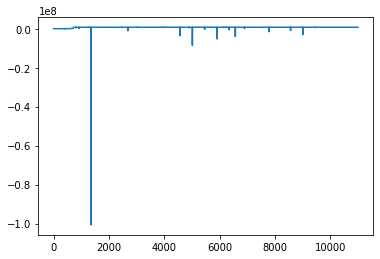

Bias: -1.6944228665083756


In [337]:
method = 'SLSQP'

start_time = time.time()
parameters, bias, f_values, optimization_result, K = train(dm_train, labels_train, method)
print('Completed in', time.time() - start_time)

x_axis = np.arange(len(f_values))
plt.plot(x_axis, f_values)
plt.show()

print('Bias:', bias)

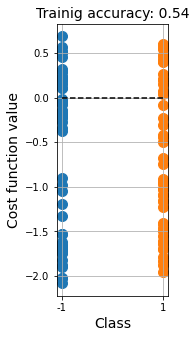

In [338]:
assignments_train, predictions_train = classify(labels_train, parameters, bias+0.985, dm_train, dm_train)

ps = 0
for i in range(n_train):
    if labels_train[i] == assignments_train[i]:
        ps += 1
acc_train = ps/n_train

predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_train):
    for j in range(n_classes):
        if labels_train[i] == class_labels[j]:
            predictions_plot[j].append(predictions_train[i])

plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    plt.scatter(x, y, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=0, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
# plt.hlines(y=1, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='solid')      
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Trainig accuracy: ' + str(acc_train), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
# plt.ylim(ymin=-1.05, ymax=1.05)
plt.grid()
plt.show()